In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

import numpy as np
import pandas as pd

import misc
import plotting
import stats
import pystan

reload(misc)
reload(plotting)

first_year = 1992

data_dir = '.'
data_file = os.path.join(data_dir, 'immigration_with_metadata_2017_03_13.csv')
data = misc.read_article_data(data_file, first_year, rename_frames=True)
print "Loaded data for %d articles" % len(data.index)

data['tone'] = data['Pro'] - data['Anti']

tone_annotations = misc.read_article_data(os.path.join(data_dir, 'immigration_tone_annotations.csv'), first_year)
print "Loaded tone annotations for %d articles" % len(tone_annotations.index)

tone_annotations['tone'] = tone_annotations['Pro'] - tone_annotations['Anti']

framing_annotations = misc.read_article_data(os.path.join(data_dir, 'immigration_framing_annotations.csv'), first_year)
framing_annotations = misc.compute_entropy(framing_annotations)
print "Loaded framing annotations for %d articles" % len(framing_annotations.index)

last_date = data['date'].max()
print "Last date = ", last_date
last_year = last_date.year + 1


Loaded data for 33868 articles
Loaded tone annotations for 3857 articles
Loaded framing annotations for 4323 articles
Last date =  2012-12-31 00:00:00


In [2]:
# extract periods from dates
reload(misc)
data = misc.convert_dates(data, first_year)
tone_annotations = misc.convert_dates(tone_annotations, first_year)
framing_annotations = misc.convert_dates(framing_annotations, first_year)

Grouped data into 84 periods


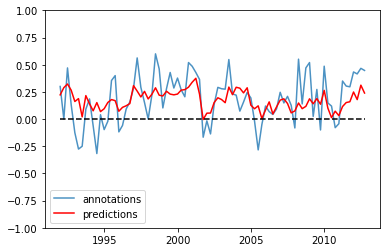

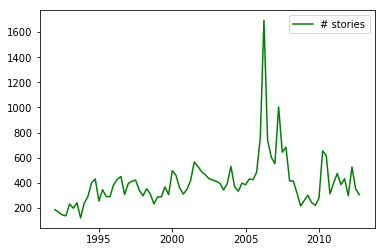

In [156]:
# decide how to group data
#group_by = 'month'
group_by = 'quarter'
#group_by = 'year'

reload(misc)
reload(plotting)

grouped = misc.group_article_data(data, group_by, first_year, group_tone=True, group_frames=True)
grouped_tone_annotations = misc.group_article_data(tone_annotations, group_by, first_year, group_tone=True)
grouped_framing_annotations = misc.group_article_data(framing_annotations, group_by, first_year, group_frames=True)

grouped = misc.compute_entropy(grouped)
grouped_framing_annotations = misc.compute_entropy(grouped_framing_annotations)

grouped['tone_a'] = grouped_tone_annotations['tone']
grouped['entropy_a'] = grouped_framing_annotations['entropy']

print "Grouped data into %d periods" % len(grouped.index)

fig, ax = plt.subplots()
#ax.fill_between(grouped_tone_annotations.f_date,  tone+tone_sd*2, tone-tone_sd*2, facecolor='grey', edgecolor='white', alpha=0.6)
ax.plot(grouped_tone_annotations.f_date, grouped_tone_annotations.tone, label='annotations', alpha=0.8)
ax.plot(grouped.f_date, grouped.tone, 'r', label='predictions')
ax.plot([grouped.f_date.min(), grouped.f_date.max()], [0, 0], 'k--')
ax.legend(loc='lower left')
ax.set_ylim(-1, 1)

fig, ax = plt.subplots()
ax.plot(grouped.f_date, grouped.stories, c='green', label='# stories')
ax.legend()

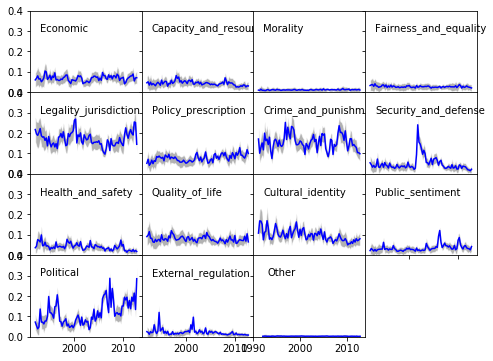

In [4]:
reload(plotting)
plotting.plot_frames(grouped, ymax=0.4)

### Load polls

1992
Loaded 69 polls
     Varname   House       Date  Topic  Subcode   L1    L2   L3   L4   C2  \
92   PSRAIMM    PSRA  5/28/1992    120      124  6.0  15.0  0.0  0.0  0.0   
14  IMMIGRAT  CBSNYT  6/21/1993    120      124  6.0  27.0  0.0  0.0  0.0   
39   IMMKEPT  GALLUP   7/9/1993    120      124  6.0  27.0  0.0  0.0  0.0   
93   PSRAIMM    PSRA  7/13/1994    120      124  5.0  12.0  0.0  0.0  0.0   
15  IMMIGRAT  CBSNYT   9/8/1994    120      124  6.0  27.0  0.0  0.0  0.0   

      ...      f_date  period  f_date_0  IMMKEPT  IMMIGRAT PSRAIMM  CNNIMM  \
92    ...     1992.25       1      0.25        0         0       1       0   
14    ...     1993.25       5      1.25        0         1       0       0   
39    ...     1993.50       6      1.50        1         0       0       0   
93    ...     1994.50      10      2.50        0         0       1       0   
15    ...     1994.50      10      2.50        0         1       0       0   

    SPIMMIG  IMMRATE  question  
92        0   

(<matplotlib.figure.Figure at 0x7f3f1f941950>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3f1f9419d0>)

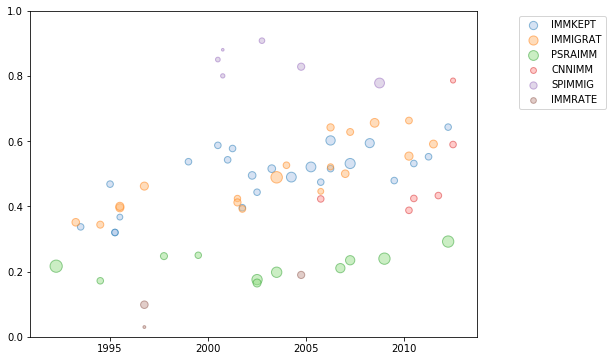

In [107]:
reload(misc)

filename = 'immigration_polls.csv'
print first_year
polls = misc.load_polls(filename, first_year, last_date)
# drop one poll that seems redundant (with a seeming mistake)
polls = polls[polls['Varname'] != 'IMMLEGAL']
polls = misc.get_f_dates(polls, first_year, group_by)
print "Loaded %d polls" % len(polls.index)

# add in indicator variables for each question
varnames = polls['Varname'].values
#questions = list(set(varnames))
#questions.sort()
questions = misc.get_top_poll_questions(polls, n=len(varnames)+1)
question_index = dict(zip(questions, range(len(questions))))    
for q_i, q in enumerate(questions):
    polls.ix[:, q] = 0
for q_i, q in enumerate(questions):
    polls.ix[polls['Varname']==q, 'question'] = q_i
    polls.ix[polls['Varname']==q, q] = 1
print polls.head() 

reload(plotting)
#plotting.plot_polling_data(polls)
plotting.plot_polling_data(polls, transform=False)

### Load data from wcalc

(0, 1)

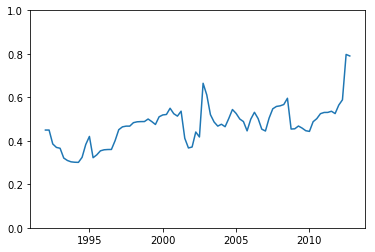

In [6]:
# Load data from wcalc
# specify the location of the mood data file
reload(misc)

group_by = 'quarter'
# read the mood data into a dataframe
if group_by == 'quarter':
    mood = pd.read_csv('wcalc_immigration_quarter.csv', header=0)
    mood['date'] = [pd.Timestamp(pd.datetime(int(mood.loc[i].year), (int(mood.loc[i].quarter))*3, 1)) for i in mood.index]
elif group_by == 'month':
    mood = pd.read_csv('wcalc_immigration_month.csv', header=0)
    mood['date'] = [pd.Timestamp(pd.datetime(int(mood.loc[i].year), int(mood.loc[i].month), 1)) for i in mood.index]
else:
    sys.exit()

mood = mood[mood['date'] >= pd.datetime(first_year, 1, 1)]
mood = mood[mood['date'] <= last_date]  

mood = misc.convert_dates(mood, first_year)
mood = misc.get_f_dates(mood, first_year, group_by)
mood.index = mood.p_quarter

# convert each quarter to a group (year/quarter)
if group_by == 'quarter':
    groups = mood.groupby('p_quarter')
elif group_by == 'month':
    groups = mood.groupby('p_month')
else:
    sys.exit()
    
# normalize and transform mood
mood['mood'] = mood['mood'] / 100.0
mood['transformed'] = np.log(mood.mood / (1 - mood.mood))

# store the vector of mood values from the previous quarter as a separate vector
mood['prev_mood'] = mood['mood'].shift().as_matrix()
mood['prev_transformed'] = mood['transformed'].shift().as_matrix()

# copy the mood data into the grouped dataframe (with the framing data)
grouped['mood'] = mood.mood
grouped['transformed'] = mood.transformed
grouped['prev_mood'] = mood.prev_mood
grouped['prev_transformed'] = mood.prev_transformed

plt.plot(mood.f_date, mood.mood)
plt.ylim(0, 1)



In [7]:
# create a "salient" variable that is 1 if the number of stories per quarter >= 350, otherwise 0
grouped['salient'] = grouped.apply(lambda row: int(row['stories'] >= 350), axis=1)

# add in interactions
grouped['toneXstories'] = grouped['tone'] * grouped['stories']
# between tone and the "salient" variable
grouped['toneXsalient'] = grouped['tone'] * grouped['salient']
# between tone and the "entropy" variable
grouped['toneXentropy'] = grouped['tone'] * grouped['entropy']

grouped['toneXstoriesXentropy'] = grouped['toneXstories'] * grouped['entropy']

grouped['toneXlogStories'] = grouped['tone'] * grouped['logStories']

grouped['aToneXstories'] = grouped['tone_a'] * grouped['stories']
grouped['aToneXaEntropy'] = grouped['tone_a'] * grouped['entropy_a']

## Approach 1: predict wcalc values from wcalc + other

### Compare some models through standard OLS

In [79]:
fitted, rmse = stats.ols(df=grouped, target='transformed', columns=['prev_transformed', 'tone'])


Rmse: 0.216923220492
                            OLS Regression Results                            
Dep. Variable:            transformed   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     98.63
Date:                Sun, 02 Apr 2017   Prob (F-statistic):           2.56e-22
Time:                        16:18:52   Log-Likelihood:                 10.597
No. Observations:                  83   AIC:                            -15.19
Df Residuals:                      80   BIC:                            -7.938
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          

In [11]:
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood',  'tone', 'stories', 'toneXstories'])


Rmse: 0.0501558708961
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     52.03
Date:                Thu, 30 Mar 2017   Prob (F-statistic):           2.85e-21
Time:                        17:54:10   Log-Likelihood:                 133.19
No. Observations:                  83   AIC:                            -256.4
Df Residuals:                      78   BIC:                            -244.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        0.0346   

In [948]:
fitted, rmse = stats.ols(df=grouped, target='transformed', columns=['prev_transformed', 'f_date_0', 'tone', 'stories'])


Rmse: 0.200269100963
                            OLS Regression Results                            
Dep. Variable:            transformed   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     61.82
Date:                Thu, 30 Mar 2017   Prob (F-statistic):           2.00e-23
Time:                        13:31:58   Log-Likelihood:                 18.278
No. Observations:                  83   AIC:                            -26.56
Df Residuals:                      78   BIC:                            -14.46
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept          

In [949]:
fitted, rmse = stats.ols(df=grouped, target='transformed', columns=['prev_transformed', 'f_date_0', 'tone', 'stories', 'toneXstories'])

Rmse: 0.201564667526
                            OLS Regression Results                            
Dep. Variable:            transformed   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     48.82
Date:                Thu, 30 Mar 2017   Prob (F-statistic):           1.68e-22
Time:                        13:32:05   Log-Likelihood:                 18.279
No. Observations:                  83   AIC:                            -24.56
Df Residuals:                      77   BIC:                            -10.04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept          

### Compare some models using leave-one-out CV

In [9]:
columns = ['prev_transformed']
predictions, rmse = stats.eval_loocv(grouped, 'transformed', columns)
print "Held-out RMSE:", rmse

columns = ['prev_transformed', 'f_date_0']
predictions, rmse = stats.eval_loocv(grouped, 'transformed', columns)
print "Held-out RMSE:", rmse

columns = ['prev_transformed', 'f_date_0', 'tone', 'stories']
predictions, rmse = stats.eval_loocv(grouped, 'transformed', columns)
print "Held-out RMSE:", rmse

columns = ['prev_transformed', 'f_date_0', 'tone', 'stories', 'toneXstories']
predictions, rmse = stats.eval_loocv(grouped, 'transformed', columns)
print "Held-out RMSE:", rmse

columns = ['prev_transformed', 'f_date_0', 'toneXstories']
predictions, rmse = stats.eval_loocv(grouped, 'transformed', columns)
print "Held-out RMSE:", rmse

columns = ['prev_transformed', 'f_date_0', 'tone', 'logStories']
predictions, rmse = stats.eval_loocv(grouped, 'transformed', columns)
print "Held-out RMSE:", rmse

columns = ['prev_transformed', 'f_date_0', 'tone', 'logStories', 'toneXlogStories']
predictions, rmse = stats.eval_loocv(grouped, 'transformed', columns)
print "Held-out RMSE:", rmse

columns = ['prev_transformed', 'f_date_0', 'toneXlogStories']
predictions, rmse = stats.eval_loocv(grouped, 'transformed', columns)
print "Held-out RMSE:", rmse

#fig, ax = plotting.plot_polling_data(polls, transform=True)
#ax.plot(grouped.f_date, grouped.transformed, label='true')
#ax.plot(grouped.f_date, predictions, label='predictions')
#ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

Held-out RMSE: 0.220389293856
Held-out RMSE: 0.212560764468
Held-out RMSE: 0.207650530213
Held-out RMSE: 0.209629936195
Held-out RMSE: 0.207545560904
Held-out RMSE: 0.2063317204
Held-out RMSE: 0.208321936214
Held-out RMSE: 0.213243883811


In [14]:
columns = ['prev_transformed', 'f_date_0', 'tone', 'toneXlogStories', 'entropy', 'toneXentropy', 'logStories']
predictions, rmse = stats.eval_loocv(grouped, 'transformed', columns)
print "Held-out RMSE:", rmse

columns = ['prev_transformed', 'f_date_0', 'tone', 'toneXlogStories', 'entropy', 'toneXentropy']
predictions, rmse = stats.eval_loocv(grouped, 'transformed', columns)
print "Held-out RMSE:", rmse

columns = ['prev_transformed', 'f_date_0', 'toneXlogStories', 'entropy', 'toneXentropy']
predictions, rmse = stats.eval_loocv(grouped, 'transformed', columns)
print "Held-out RMSE:", rmse



Held-out RMSE: 0.197939043728
Held-out RMSE: 0.196325883565
Held-out RMSE: 0.201765390368


In [15]:
columns = ['prev_mood', 'f_date_0', 'toneXlogStories']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse

columns = ['prev_mood', 'f_date_0', 'tone', 'toneXlogStories', 'entropy', 'toneXentropy', 'logStories']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse

columns = ['prev_mood', 'f_date_0', 'tone', 'toneXlogStories', 'entropy', 'toneXentropy']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse

columns = ['prev_mood', 'f_date_0', 'toneXlogStories', 'entropy', 'toneXentropy']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse



Held-out RMSE: 0.0496475397412
Held-out RMSE: 0.0460127545731
Held-out RMSE: 0.0456076647664
Held-out RMSE: 0.0467593715244


### Try running a Bayesian linear regression model

In [802]:
model = """
/*
*Simple normal regression example
*/

data {
  int N; //the number of observations
  int K; //the number of columns in the model matrix
  real y[N]; //the response
  matrix[N,K] X; //the model matrix
}
parameters {
  vector[K] beta; //the regression parameters
  real sigma; //the standard deviation
}
transformed parameters {
  vector[N] linpred;
  linpred <- X*beta;
}
model {  
  beta[1] ~ cauchy(0,10); //prior for the intercept following Gelman 2008

  for(i in 2:K)
   beta[i] ~ cauchy(0,2.5);//prior for the slopes following Gelman 2008
  
  y ~ normal(linpred,sigma);
}
"""


In [814]:
columns = ['prev_transformed', 'tone', 'logStories', 'toneXlogStories']

X = grouped[columns].copy()
X = sm.add_constant(X).values[1:, :]
N, K = X.shape
y = grouped['transformed'].values[1:]

data = {'N': N, 'K': K, 'y': y, 'X': X}

# fit the model
fit = pystan.stan(model_code=model, data=data, iter=1000, chains=4)

betas = fit.extract('beta')['beta']
betas_means = np.mean(betas, axis=0)
betas_stds2 = np.std(betas, axis=0) * 2
for c_i, c in enumerate(['Intercept'] + columns):
    print "%20s \t  %0.4f  %0.4f  %0.4f" % (c, betas_means[c_i] - betas_stds2[c_i], betas_means[c_i], betas_means[c_i] + betas_stds2[c_i])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_67a5fef2fa8062f0d36b04444770661b NOW.


           Intercept 	 0.2247  1.5076
    prev_transformed 	 0.3105  0.9713
                tone 	 0.2347  0.6182
          logStories 	 0.2477  0.9072
     toneXlogStories 	 0.2566  0.9066


## Approach 2: predicting poll results from wcalc

In [108]:
reload(misc)

# grab tone and prev_mood data for each poll
tones = []
prev_moods = []
stories = []
entropies = []
for i in polls.index:
    if group_by == 'month':
        period = polls.loc[i]['p_month']
    elif group_by == 'quarter':
        period = polls.loc[i]['p_quarter']
    tones.append(grouped.loc[period]['tone'])
    prev_moods.append(mood.loc[period-1]['prev_mood'])
    stories.append(grouped.loc[period]['stories'])
    entropies.append(grouped.loc[period]['entropy'])
polls['tone'] = tones
polls['prev_mood'] = prev_moods
polls['prev_transformed'] = np.log(polls.prev_mood / (1 - polls.prev_mood))
polls['stories'] = stories
polls['logStories'] = np.log(stories) - np.mean(np.log(stories))
polls['entropy'] = entropies
polls['toneXstories'] = polls['tone'] * polls['stories']
polls['toneXlogStories'] = polls['tone'] * polls['logStories']
polls['toneXentropy'] = polls['tone'] * polls['entropy']
polls = misc.combine_polls_with_preceeding_articles(polls, data, n_days=30, include_tone=True, include_frames=True)



In [11]:
reload(stats)
poll_names = misc.get_top_poll_questions(polls)[1:]
columns = ['prev_mood', 'pTone', 'pLogStories', 'pEntropy', 'pToneXpLogStories', 'pToneXpEntropy'] + poll_names
target = 'value'
fitted, rmse = stats.ols(df=polls, target=target, columns=columns, weight_column='N')
predictions, rmse_cv = stats.eval_loocv(polls, target, columns, weight_column='N')
print rmse_cv

Rmse: 0.0651904746696
                            WLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.884
Model:                            WLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     38.70
Date:                Sun, 02 Apr 2017   Prob (F-statistic):           3.75e-22
Time:                        14:48:00   Log-Likelihood:                 91.048
No. Observations:                  68   AIC:                            -158.1
Df Residuals:                      56   BIC:                            -131.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept       

In [857]:
reload(stats)
poll_names = misc.get_top_poll_questions(polls)[1:]
columns = ['prev_transformed', 'tone', 'logStories', 'entropy'] + poll_names
target = 'transformed'
fitted, rmse = stats.ols(df=polls, target=target, columns=columns, weight_column='N')
predictions, rmse_cv = stats.eval_loocv(polls, target, columns, weight_column='N')
print rmse_cv

Rmse: 0.291878602894
                            WLS Regression Results                            
Dep. Variable:            transformed   R-squared:                       0.891
Model:                            WLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     52.81
Date:                Wed, 29 Mar 2017   Prob (F-statistic):           1.14e-24
Time:                        17:58:56   Log-Likelihood:                -12.079
No. Observations:                  68   AIC:                             44.16
Df Residuals:                      58   BIC:                             66.35
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept          

Question	Responses
 IMMKEPT	24
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3


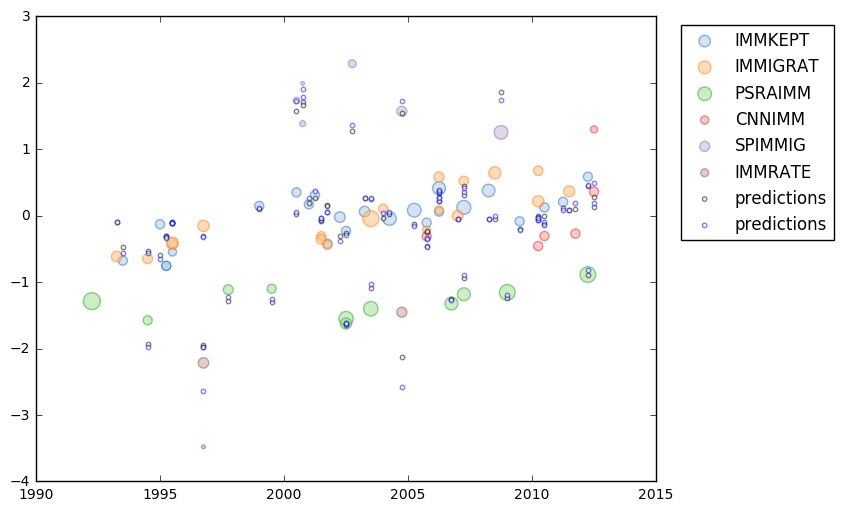

In [825]:
fig, ax = plotting.plot_polling_data(polls, transform=True)
ax.scatter(polls.f_date, predictions, s=10, facecolor='white', edgecolor='black', label='predictions', alpha=0.5)
ax.scatter(polls.f_date, predictions2, s=10, facecolor='white', edgecolor='blue', label='predictions', alpha=0.5)
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

### Try a hierarchical Bayesian model

In [858]:
model = """
/*
*Hierarchical model for polls
*/

data {
  int N; // the number of observations
  int K; // the number of columns in the model matrix
  int P; // number of poll indicators
  real y[N]; // the response
  matrix[N,K] X; // the model matrix
  matrix[N,P] polls_matrix;
}
parameters {
  vector[K] beta; // the regression parameters
  vector[P] poll_offsets; 
  real offset_mean;
  real<lower=0> offset_std;
  real<lower=0> sigma; // the standard deviation
}
transformed parameters {
  vector[N] linpred;
  linpred = X * beta + polls_matrix * poll_offsets;
}
model {  
  beta[1] ~ cauchy(0,10); //prior for the intercept following Gelman 2008

  for(i in 2:K)
   beta[i] ~ cauchy(0,2.5); //prior for the slopes following Gelman 2008

  for(j in 1:P)
    poll_offsets[j] ~ normal(offset_mean, offset_std);

  offset_mean ~ normal(0, 1);
  offset_std ~ cauchy(0, 2.5);

  y ~ normal(linpred,sigma);
}
"""



In [866]:
target = 'transformed'
columns = ['prev_transformed', 'tone', 'stories', 'toneXstories', 'entropy', 'entropyXtone']
poll_names = misc.get_top_poll_questions(polls)

X = polls[columns].copy()
polls_indicators = polls[poll_names].values[1:, :]
X = sm.add_constant(X).values[1:, :]
N, K = X.shape
P = len(poll_names)
y = polls[target].values[1:]

stan_data = {'N': N, 'K': K, 'P': P, 'y': y, 'X': X, 'polls_matrix': polls_indicators}

# fit the model
fit = pystan.stan(model_code=model, data=stan_data, iter=1000, chains=4)

betas = fit.extract('beta')['beta']
betas_means = np.mean(betas, axis=0)
betas_stds2 = np.std(betas, axis=0) * 2
for c_i, c in enumerate(['Intercept'] + columns):
    print "%20s \t  %0.4f  %0.4f  %0.4f" % (c, betas_means[c_i] - betas_stds2[c_i], betas_means[c_i], betas_means[c_i] + betas_stds2[c_i])
    
offsets = fit.extract('poll_offsets')['poll_offsets']
offset_means = np.mean(offsets, axis=0)
offset_stds2 = np.std(offsets, axis=0) * 2
for c_i, c in enumerate(poll_names):
    print "%20s \t  %0.4f  %0.4f  %0.4f" % (c, offset_means[c_i] - offset_stds2[c_i], offset_means[c_i], offset_means[c_i] + offset_stds2[c_i])    

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e510440cbefb6c7a37977e69248e032e NOW.


           Intercept 	  -1.1780  3.2411  7.6603
    prev_transformed 	  0.0740  0.3930  0.7120
                tone 	  -7.3217  2.3655  12.0526
             stories 	  -0.0013  0.0004  0.0020
        toneXstories 	  -0.0103  -0.0001  0.0101
             entropy 	  -3.2673  -1.7349  -0.2026
        entropyXtone 	  -4.2246  -0.3461  3.5324
             IMMKEPT 	  -1.9412  0.5158  2.9729
            IMMIGRAT 	  -1.9493  0.5046  2.9586
             PSRAIMM 	  -3.2527  -0.7925  1.6678
              CNNIMM 	  -2.0282  0.4214  2.8710
             SPIMMIG 	  -0.3162  2.1428  4.6018
             IMMRATE 	  -4.1237  -1.6329  0.8579


0.0708061612021


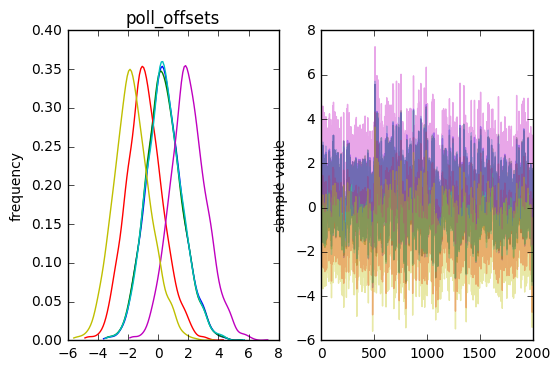

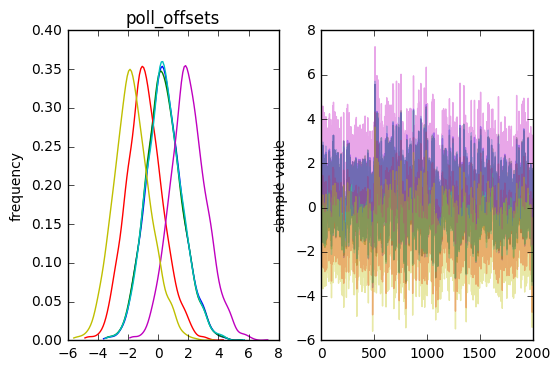

In [863]:
print np.mean(fit.extract('offset_mean')['offset_mean'])
fit.plot('poll_offsets')

In [860]:
reload(stats)
poll_names = misc.get_top_poll_questions(polls)[1:]
columns = ['prev_transformed', 'tone', 'logStories', 'toneXlogStories'] + poll_names
target = 'transformed'
fitted, rmse = stats.ols(df=polls, target=target, columns=columns)
print rmse_cv

Rmse: 0.372592881738
                            OLS Regression Results                            
Dep. Variable:            transformed   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     42.86
Date:                Wed, 29 Mar 2017   Prob (F-statistic):           2.15e-22
Time:                        18:00:45   Log-Likelihood:                -23.945
No. Observations:                  68   AIC:                             67.89
Df Residuals:                      58   BIC:                             90.09
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept          

## Approach 3: Try estimating my own latent state of mood

### Try estimating a latent mood using only the polls

In [139]:
# MODEL with no temporal covariates (just polls)

model = """
/*
* Simple latent space model for mood
*/

data {
  int N; // number of polls
  int T; // number of time steps
  int Q; // number of different questions
  int y[N]; // poll results
  int t[N]; // time indicies of polls
  int n[N]; // sample size for each poll
  row_vector[Q] q[N];  // indicators for poll questions
  int N_new;          // number of test points
  int y_new[N_new];
  int t_new[N_new];
  int n_new[N_new];
  row_vector[Q] q_new[N_new];
}
parameters {
  real<lower=0, upper=1> p_t_0; // unconstrained latent mood at timestep 0
  vector[T] mu;  // latent mood variable in real space
  real<lower=0> sigma_mu;  // variance of transitions in mu
  vector[Q] offsets; // offset for each question in real space
  real offset_mean;
  real<lower=0> offset_var; // offset variance 
  real alpha; // intercept in AR model
  real alpha_mean;
  real<lower=0> alpha_var;
  real beta; // weight parameter on previous mu
  real beta_mean; 
  real<lower=0> beta_var;
}
transformed parameters {  
  real mu_0;  // p_t_0 transformed to real space
  mu_0 = logit(p_t_0);
}
model {  
  sigma_mu ~ cauchy(0, 2.5);
  alpha_var ~ cauchy(0, 2.5);
  alpha_mean ~ normal(0, 1);
  alpha ~ normal(alpha_mean, alpha_var);
  beta_var ~ cauchy(0, 2.5);
  beta_mean ~ normal(1, 1);  // assume mu[t] \approx mu[t-1] as a prior
  beta ~ normal(beta_mean, beta_var);

p_t_0 ~ uniform(0, 1);
  mu[1] ~ normal(alpha + beta * mu_0, sigma_mu);
  for (j in 2:T) {
    mu[j] ~ normal(alpha + beta * mu[j-1], sigma_mu);
  }
  offset_var ~ cauchy(0, 2.5);
  offset_mean ~ normal(0, 1);
  for (k in 1:Q) {
     offsets[k] ~ normal(offset_mean, offset_var);
  }
  for (i in 1:N) {
    y[i] ~ binomial_logit(n[i], mu[t[i]] + q[i] * offsets);
  }
}
generated quantities {
  vector[T] p_t; // mu variables transformed into (0, 1)
  vector[N] p_i; 
  vector[N_new] p_i_new;

  // store the log prob of held out observations
  real log_p_new;        // posterior predictive log density remaining trials
  vector[N_new] log_p_news;  // posterior predictive log density for item  
  
  // store simulated draws from the posterior
  int<lower=0> s_new[N_new];

  for (j in 1:T)
    p_t[j] = inv_logit(mu[j] + offset_mean);
  for (i in 1:N)
    p_i[i] = inv_logit(mu[t[i]] + q[i] * offsets);
  for (i in 1:N_new)
    p_i_new[i] = inv_logit(mu[t_new[i]] + q_new[i] * offsets);

  // calculate likelihood of held-out data
  for (i in 1:N_new)
    log_p_news[i] = binomial_lpmf(y_new[i] | n_new[i], p_i_new[i]);
  log_p_new = sum(log_p_news);  // sum the log probs of each obseration
  
  // simluate data from posterior for posterior predictive checks
  for (i in 1:N_new) {
    s_new[i] = binomial_rng(n_new[i], p_i_new[i]);
  }
}
"""



In [140]:
tones = grouped.tone.values
logStories = grouped.logStories.values
toneXlogStories = tones * logStories
entropy = grouped.entropy.values
toneXentropy = tones * entropy
X = np.vstack([tones, logStories, entropy, toneXentropy]).T
n_periods, K = X.shape
n_polls, _ = polls.shape
periods = np.array(polls.p_quarter.values, dtype=int) + 1
n_questions = int(polls.question.max() + 1) 
question_indices = np.array(polls.question.values, dtype=int) + 1
question_indicators = np.zeros([n_polls, n_questions])
for i in range(n_polls):
    question_indicators[i, polls.question.values[i]] = 1
    
y = np.array((polls.value * polls.N).values, dtype=int)
t = np.array(polls.p_quarter.values, dtype=int) + 1
stan_data = {'N': n_polls, 'T': n_periods, 'Q': n_questions,
             'y': y, 't': periods, 'n': polls.N.values, 'q': question_indicators,
             'N_new': n_polls,
             'y_new': y, 't_new': periods, 'n_new': polls.N.values, 'q_new': question_indicators}
n_chains = 4
n_iter = 2000
fit = pystan.stan(model_code=model, data=stan_data, iter=n_iter, chains=4)


/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


Question	Responses
 IMMKEPT	24
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3


''

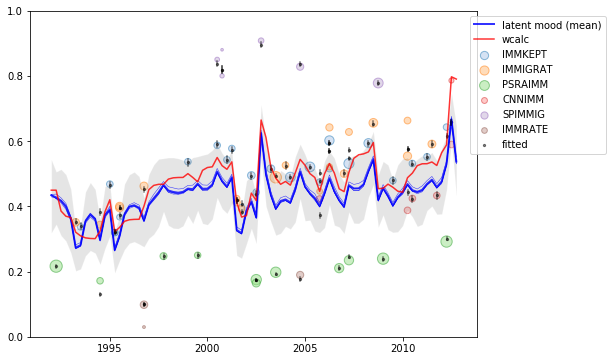

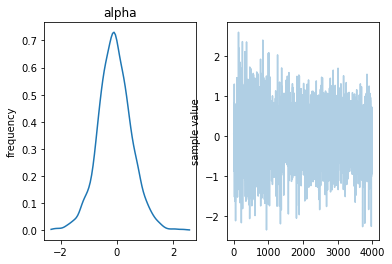

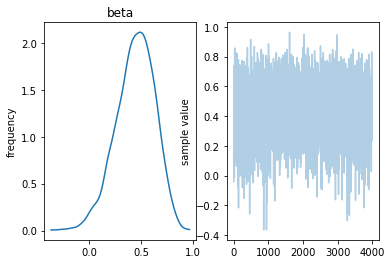

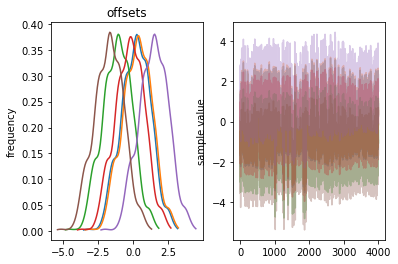

In [142]:
reload(plotting)

p_t = fit.extract('p_t')['p_t']
p_i = fit.extract('p_i')['p_i']
p_t_means = np.mean(p_t, axis=0)
p_t_25 = np.percentile(p_t, 25, axis=0)
p_t_75 = np.percentile(p_t, 75, axis=0)
p_i_means = np.mean(p_i, axis=0)
p_i_25 = np.percentile(p_i, 25, axis=0)
p_i_75 = np.percentile(p_i, 75, axis=0)
fig, ax = plotting.plot_polling_data(polls)
x = [first_year + (q) * 0.25 for q in range(n_periods)]
ax.fill_between(x,  p_t_25, p_t_75, facecolor='grey', edgecolor='white', alpha=0.2, label=None)
for i in range(n_chains):
    ax.plot(x, np.mean(p_t[i*n_iter/2:(i+1)*n_iter/2, :], axis=0), 'b', linewidth=0.5, alpha=0.8, label=None)    
ax.plot(x, p_t_means, 'b', linewidth=2, alpha=0.8, label='latent mood (mean)')
ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
ax.scatter(polls.f_date, p_i_means, s=5, facecolor='black', edgecolor='black', label='fitted', alpha=0.5)
for i in range(n_polls):
    f_date = polls.f_date.iloc[i]
    ax.plot([f_date, f_date], [p_i_25[i], p_i_75[i]], 'k', label=None, alpha=0.5)
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

fit.plot('alpha')
fit.plot('beta')
#fit.plot('gamma')
fit.plot('offsets')

""

/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


Question	Responses
 IMMKEPT	24
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3
fold 0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


fold 1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


fold 2


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


fold 3


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


fold 4


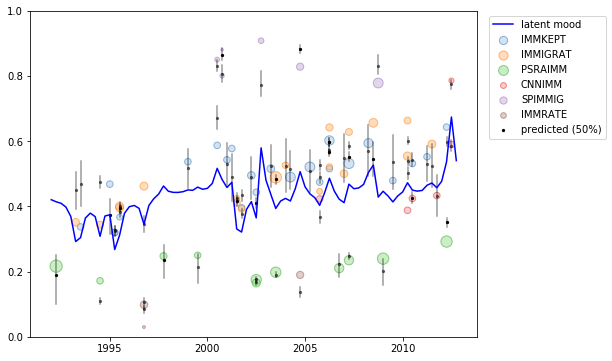

In [143]:
fig, ax = plotting.plot_polling_data(polls)

n_questions = int(polls.question.max() + 1)
n_periods = len(grouped.index)
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
p_t_mean = np.zeros(n_periods)

n_folds = 5
for fold in range(n_folds):
    print "fold", fold
    polls_train = polls[polls.fold != fold]
    polls_test = polls[polls.fold == fold]
    N_train, _ = polls_train.shape
    N_test, _ = polls_test.shape
    question_indices = np.array(polls.question.values, dtype=int) + 1
    question_indicators_train = np.zeros([N_train, n_questions])
    question_indicators_test = np.zeros([N_test, n_questions])
    for i in range(N_train):
        question_indicators_train[i, polls_train.question.values[i]] = 1
    for i in range(N_test):
        question_indicators_test[i, polls_test.question.values[i]] = 1

    y_train = np.array((polls_train.value * polls_train.N).values, dtype=int)
    y_test = np.array((polls_test.value * polls_test.N).values, dtype=int)
    t_train = np.array(polls_train.period.values, dtype=int) + 1
    t_test = np.array(polls_test.period.values, dtype=int) + 1
        
    stan_data = {'N': N_train, 'T': n_periods, 'Q': n_questions,
                 'y': y_train, 't': t_train, 'n': polls_train.N.values, 'q': question_indicators_train,
                 'N_new': N_test,
                 'y_new': y_test, 't_new': t_test, 'n_new': polls_test.N.values, 'q_new': question_indicators_test}
    fit = pystan.stan(model_code=model, data=stan_data, iter=1000, chains=4)

    p_t = fit.extract('p_t')['p_t']
    p_t_mean += np.mean(p_t, axis=0)
    p_i_new = fit.extract('p_i_new')['p_i_new']
    p_i_new_means = np.mean(p_i_new, axis=0)
    p_i_new_25 = np.percentile(p_i_new, 25, axis=0)
    p_i_new_75 = np.percentile(p_i_new, 75, axis=0)
    s_new = fit.extract('s_new')['s_new'] 
    s_new_mean = np.mean(s_new, axis=0) / polls_test.N.values
    s_new_25 = np.percentile(s_new, 25, axis=0) / polls_test.N.values
    s_new_75 = np.percentile(s_new, 75, axis=0) / polls_test.N.values
    x = [first_year + (q) * 0.25 for q in range(n_periods)]
    #ax.fill_between(x,  p_t_means+p_t_std*2, p_t_means-p_t_std*2, facecolor='grey', edgecolor='white', alpha=0.3, label=None)
    if fold == 0:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label='latent mood')
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label='predicted (50%)')
    else:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label=None)
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label=None, alpha=0.5)
    for i in range(N_test):
        f_date = polls_test.f_date.iloc[i]
        ax.plot([f_date, f_date], [s_new_25[i], s_new_75[i]], 'k', label=None, alpha=0.4)

ax.plot(x, p_t_mean/float(n_folds), 'b', label='latent mood')
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

from scipy.misc import logsumexp
log_p_new = fit.extract('log_p_new')['log_p_new']
n_iter = log_p_new.size
posterior_predictive = logsumexp(log_p_new) - np.log(n_iter)
print "log_p_new: %0.2f" % posterior_predictive

In [144]:
from scipy.misc import logsumexp
log_p_new = fit.extract('log_p_new')['log_p_new']
n_iter = log_p_new.size
posterior_predictive = logsumexp(log_p_new) - np.log(n_iter)
print "log_p_new: %0.2f" % posterior_predictive

log_p_new: -77.39


In [146]:
# EXTEND MODEL with weights and covariates

model = """
/*
* Simple latent space model for mood
*/

data {
  int N; // number of polls
  int T; // number of time steps
  int Q; // number of different questions
  int K; // number of covariates
  row_vector[K] X[T];  // covariates: shape of matrix[T, K]
  int y[N]; // poll results
  int t[N]; // time indicies of polls
  int n[N]; // sample size for each poll
  row_vector[Q] q[N];  // indicators for poll questions
  int N_new;          // number of test points
  int y_new[N_new];
  int t_new[N_new];
  int n_new[N_new];
  row_vector[Q] q_new[N_new];
}
parameters {
  real<lower=0, upper=1> p_t_0; // unconstrained latent mood at timestep 0
  vector[T] mu;  // latent mood variable in real space
  real<lower=0> sigma_mu;  // variance of transitions in mu
  vector[Q] offsets; // offset for each question in real space
  real offset_mean;
  real<lower=0> offset_var; // offset variance 
  real alpha; // intercept in AR model
  real alpha_mean;
  real<lower=0> alpha_var;
  real beta; // weight parameter on previous mu
  real beta_mean; 
  real<lower=0> beta_var;
  vector[K] gamma; // weights on covariates
  real gamma_mean;
}
transformed parameters {  
  real mu_0;  // p_t_0 transformed to real space
  mu_0 = logit(p_t_0);
}
model {  
  sigma_mu ~ cauchy(0, 2.5);
  alpha_var ~ cauchy(0, 2.5);
  alpha_mean ~ normal(0, 1);
  alpha ~ normal(alpha_mean, alpha_var);
  beta_var ~ cauchy(0, 2.5);
  beta_mean ~ normal(1, 1);  // assume mu[t] \approx mu[t-1] as a prior
  beta ~ normal(beta_mean, beta_var);
  gamma_mean ~ normal(0, 1);
  for (k in 1:K)
    gamma[k] ~ normal(gamma_mean, beta_var);  // use same variance as weight on previous mu

  p_t_0 ~ uniform(0, 1);
  mu[1] ~ normal(alpha + beta * mu_0 + X[1] * gamma, sigma_mu);
  for (j in 2:T) {
    mu[j] ~ normal(alpha + beta * mu[j-1] + X[j] * gamma, sigma_mu);
  }
  offset_var ~ cauchy(0, 2.5);
  offset_mean ~ normal(0, 1);
  for (k in 1:Q) {
     offsets[k] ~ normal(offset_mean, offset_var);
  }
  for (i in 1:N) {
    y[i] ~ binomial_logit(n[i], mu[t[i]] + q[i] * offsets);
  }
}
generated quantities {
  vector[T] p_t; // mu variables transformed into (0, 1)
  vector[N] p_i; 
  vector[N_new] p_i_new;

  // store the log prob of held out observations
  real log_p_new;        // posterior predictive log density remaining trials
  vector[N_new] log_p_news;  // posterior predictive log density for item  
  
  // store simulated draws from the posterior
  int<lower=0> s_new[N_new];

  for (j in 1:T)
    p_t[j] = inv_logit(mu[j] + offset_mean);
  for (i in 1:N)
    p_i[i] = inv_logit(mu[t[i]] + q[i] * offsets);
  for (i in 1:N_new)
    p_i_new[i] = inv_logit(mu[t_new[i]] + q_new[i] * offsets);

  // calculate likelihood of held-out data
  for (i in 1:N_new)
    log_p_news[i] = binomial_lpmf(y_new[i] | n_new[i], p_i_new[i]);
  log_p_new = sum(log_p_news);  // sum the log probs of each obseration
  
  // simluate data from posterior for posterior predictive checks
  for (i in 1:N_new) {
    s_new[i] = binomial_rng(n_new[i], p_i_new[i]);
  }
}
"""



In [137]:
tones = grouped.tone.values
logStories = grouped.logStories.values
toneXlogStories = tones * logStories
entropy = grouped.entropy.values
toneXentropy = tones * entropy
X = np.vstack([tones, logStories, entropy, toneXentropy]).T
n_periods, K = X.shape
n_polls, _ = polls.shape
periods = np.array(polls.p_quarter.values, dtype=int) + 1
n_questions = int(polls.question.max() + 1) 
question_indices = np.array(polls.question.values, dtype=int) + 1
question_indicators = np.zeros([n_polls, n_questions])
for i in range(n_polls):
    question_indicators[i, polls.question.values[i]] = 1
    
y = np.array((polls.value * polls.N).values, dtype=int)
t = np.array(polls.p_quarter.values, dtype=int) + 1
stan_data = {'N': n_polls, 'T': n_periods, 'K': K, 'Q': n_questions,
             'y': y, 't': periods, 'n': polls.N.values, 'q': question_indicators, 'X': X,
             'N_new': n_polls,
             'y_new': y, 't_new': periods, 'n_new': polls.N.values, 'q_new': question_indicators}
n_chains = 4
n_iter = 2000
fit = pystan.stan(model_code=model, data=stan_data, iter=n_iter, chains=4)


/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4acb99437be88a723d3f97b7abdb2e99 NOW.


Question	Responses
 IMMKEPT	24
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3
[ 0.07356915  0.08434608 -0.00838747  0.04680684]
[-0.52782407 -0.07522242 -0.07369195 -0.3074545 ]
[ 0.82617142  0.30006196  0.04368503  0.39171107]


''

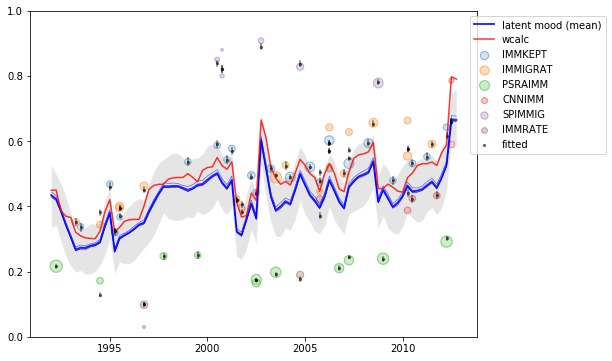

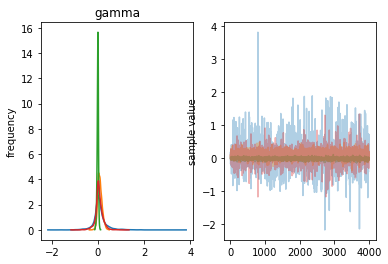

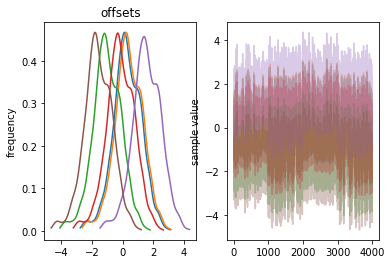

In [138]:
reload(plotting)

p_t = fit.extract('p_t')['p_t']
p_i = fit.extract('p_i')['p_i']
p_t_means = np.mean(p_t, axis=0)
p_t_25 = np.percentile(p_t, 25, axis=0)
p_t_75 = np.percentile(p_t, 75, axis=0)
p_i_means = np.mean(p_i, axis=0)
p_i_25 = np.percentile(p_i, 25, axis=0)
p_i_75 = np.percentile(p_i, 75, axis=0)
fig, ax = plotting.plot_polling_data(polls)
x = [first_year + (q) * 0.25 for q in range(n_periods)]
ax.fill_between(x,  p_t_25, p_t_75, facecolor='grey', edgecolor='white', alpha=0.2, label=None)
for i in range(n_chains):
    ax.plot(x, np.mean(p_t[i*n_iter/2:(i+1)*n_iter/2, :], axis=0), 'b', linewidth=0.5, alpha=0.8, label=None)    
ax.plot(x, p_t_means, 'b', linewidth=2, alpha=0.8, label='latent mood (mean)')
ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
ax.scatter(polls.f_date, p_i_means, s=5, facecolor='black', edgecolor='black', label='fitted', alpha=0.5)
for i in range(n_polls):
    f_date = polls.f_date.iloc[i]
    ax.plot([f_date, f_date], [p_i_25[i], p_i_75[i]], 'k', label=None, alpha=0.5)
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

#fit.plot('alpha')
#fit.plot('beta')
fit.plot('gamma')
fit.plot('offsets')

gamma = fit.extract('gamma')['gamma']
print np.mean(gamma, axis=0)
print np.percentile(gamma, 2.5, axis=0)
print np.percentile(gamma, 97.5, axis=0)

""

/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


Question	Responses
 IMMKEPT	24
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3
(84, 2)
fold 0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[  7.42452082e-01   3.24055311e-04]
[  5.53477498e-01   2.09563797e-04]
fold 1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[  5.43836776e-01   2.64584697e-04]
[  5.03089513e-01   1.98579654e-04]
fold 2


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[  7.25155428e-01   4.19364090e-04]
[  6.06146065e-01   2.26398742e-04]
fold 3


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[  9.14515728e-01   2.29842710e-04]
[  7.68654664e-01   3.00533472e-04]
fold 4
[  7.03032583e-01   2.95263790e-04]
[  5.46027773e-01   2.17815281e-04]
log_p_new: -80.08


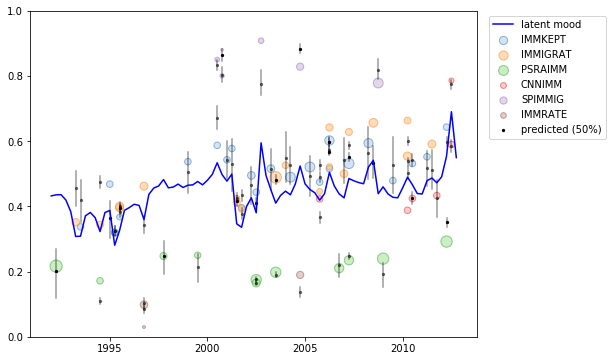

In [148]:
# TONE, STORIES

fig, ax = plotting.plot_polling_data(polls)

n_questions = int(polls.question.max() + 1)
n_periods = len(grouped.index)
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
p_t_mean = np.zeros(n_periods)

tones = grouped.tone.values
stories = grouped.stories.values
#toneXlogStories = tones * logStories
entropy = grouped.entropy.values
toneXentropy = tones * entropy

X = np.vstack([tones, stories]).T
n_periods, K = X.shape
print X.shape

n_folds = 5
for fold in range(n_folds):
    print "fold", fold
    polls_train = polls[polls.fold != fold]
    polls_test = polls[polls.fold == fold]
    N_train, _ = polls_train.shape
    N_test, _ = polls_test.shape
    question_indices = np.array(polls.question.values, dtype=int) + 1
    question_indicators_train = np.zeros([N_train, n_questions])
    question_indicators_test = np.zeros([N_test, n_questions])
    for i in range(N_train):
        question_indicators_train[i, polls_train.question.values[i]] = 1
    for i in range(N_test):
        question_indicators_test[i, polls_test.question.values[i]] = 1

    y_train = np.array((polls_train.value * polls_train.N).values, dtype=int)
    y_test = np.array((polls_test.value * polls_test.N).values, dtype=int)
    t_train = np.array(polls_train.period.values, dtype=int) + 1
    t_test = np.array(polls_test.period.values, dtype=int) + 1
        
    stan_data = {'N': N_train, 'T': n_periods, 'K':K, 'Q': n_questions,
                 'y': y_train, 't': t_train, 'n': polls_train.N.values, 'q': question_indicators_train, 'X': X,
                 'N_new': N_test,
                 'y_new': y_test, 't_new': t_test, 'n_new': polls_test.N.values, 'q_new': question_indicators_test}
    fit = pystan.stan(model_code=model, data=stan_data, iter=1000, chains=4)

    p_t = fit.extract('p_t')['p_t']
    p_t_mean += np.mean(p_t, axis=0)
    p_i_new = fit.extract('p_i_new')['p_i_new']
    p_i_new_means = np.mean(p_i_new, axis=0)
    p_i_new_25 = np.percentile(p_i_new, 25, axis=0)
    p_i_new_75 = np.percentile(p_i_new, 75, axis=0)
    s_new = fit.extract('s_new')['s_new'] 
    s_new_mean = np.mean(s_new, axis=0) / polls_test.N.values
    s_new_25 = np.percentile(s_new, 25, axis=0) / polls_test.N.values
    s_new_75 = np.percentile(s_new, 75, axis=0) / polls_test.N.values
    x = [first_year + (q) * 0.25 for q in range(n_periods)]
    #ax.fill_between(x,  p_t_means+p_t_std*2, p_t_means-p_t_std*2, facecolor='grey', edgecolor='white', alpha=0.3, label=None)
    if fold == 0:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label='latent mood')
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label='predicted (50%)')
    else:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label=None)
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label=None, alpha=0.5)
    for i in range(N_test):
        f_date = polls_test.f_date.iloc[i]
        ax.plot([f_date, f_date], [s_new_25[i], s_new_75[i]], 'k', label=None, alpha=0.4)
        
    gamma = fit.extract('gamma')['gamma']
    print np.mean(gamma, axis=0)
    print np.std(gamma, axis=0)

ax.plot(x, p_t_mean/float(n_folds), 'b', label='latent mood')
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

from scipy.misc import logsumexp
log_p_new = fit.extract('log_p_new')['log_p_new']
n_iter = log_p_new.size
posterior_predictive = logsumexp(log_p_new) - np.log(n_iter)
print "log_p_new: %0.2f" % posterior_predictive

/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


Question	Responses
 IMMKEPT	24
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3
(84, 2)
fold 0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.89009492  0.24915409]
[ 0.55823527  0.12181713]
fold 1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.58937963  0.19753713]
[ 0.47229189  0.11102045]
fold 2


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.84152718  0.29923394]
[ 0.57152296  0.13996208]
fold 3


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 1.02498212  0.23883013]
[ 0.79150634  0.16798823]
fold 4
[ 0.71816067  0.23572016]
[ 0.51708248  0.12438089]
log_p_new: -73.79


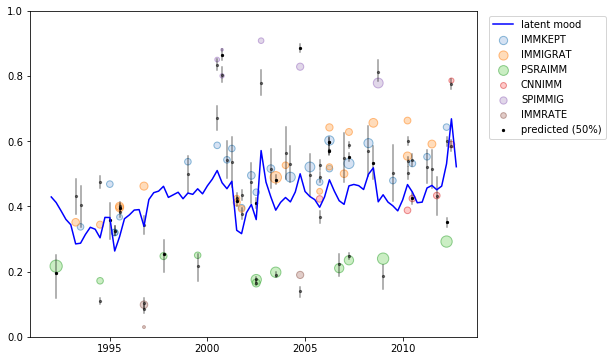

In [150]:
# TONE, logSTORIES

fig, ax = plotting.plot_polling_data(polls)

n_questions = int(polls.question.max() + 1)
n_periods = len(grouped.index)
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
p_t_mean = np.zeros(n_periods)

tones = grouped.tone.values
logStories = grouped.logStories.values
#toneXlogStories = tones * logStories
entropy = grouped.entropy.values
toneXentropy = tones * entropy

X = np.vstack([tones, logStories]).T
n_periods, K = X.shape
print X.shape

n_folds = 5
for fold in range(n_folds):
    print "fold", fold
    polls_train = polls[polls.fold != fold]
    polls_test = polls[polls.fold == fold]
    N_train, _ = polls_train.shape
    N_test, _ = polls_test.shape
    question_indices = np.array(polls.question.values, dtype=int) + 1
    question_indicators_train = np.zeros([N_train, n_questions])
    question_indicators_test = np.zeros([N_test, n_questions])
    for i in range(N_train):
        question_indicators_train[i, polls_train.question.values[i]] = 1
    for i in range(N_test):
        question_indicators_test[i, polls_test.question.values[i]] = 1

    y_train = np.array((polls_train.value * polls_train.N).values, dtype=int)
    y_test = np.array((polls_test.value * polls_test.N).values, dtype=int)
    t_train = np.array(polls_train.period.values, dtype=int) + 1
    t_test = np.array(polls_test.period.values, dtype=int) + 1
        
    stan_data = {'N': N_train, 'T': n_periods, 'K':K, 'Q': n_questions,
                 'y': y_train, 't': t_train, 'n': polls_train.N.values, 'q': question_indicators_train, 'X': X,
                 'N_new': N_test,
                 'y_new': y_test, 't_new': t_test, 'n_new': polls_test.N.values, 'q_new': question_indicators_test}
    fit = pystan.stan(model_code=model, data=stan_data, iter=1000, chains=4)

    p_t = fit.extract('p_t')['p_t']
    p_t_mean += np.mean(p_t, axis=0)
    p_i_new = fit.extract('p_i_new')['p_i_new']
    p_i_new_means = np.mean(p_i_new, axis=0)
    p_i_new_25 = np.percentile(p_i_new, 25, axis=0)
    p_i_new_75 = np.percentile(p_i_new, 75, axis=0)
    s_new = fit.extract('s_new')['s_new'] 
    s_new_mean = np.mean(s_new, axis=0) / polls_test.N.values
    s_new_25 = np.percentile(s_new, 25, axis=0) / polls_test.N.values
    s_new_75 = np.percentile(s_new, 75, axis=0) / polls_test.N.values
    x = [first_year + (q) * 0.25 for q in range(n_periods)]
    #ax.fill_between(x,  p_t_means+p_t_std*2, p_t_means-p_t_std*2, facecolor='grey', edgecolor='white', alpha=0.3, label=None)
    if fold == 0:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label='latent mood')
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label='predicted (50%)')
    else:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label=None)
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label=None, alpha=0.5)
    for i in range(N_test):
        f_date = polls_test.f_date.iloc[i]
        ax.plot([f_date, f_date], [s_new_25[i], s_new_75[i]], 'k', label=None, alpha=0.4)
        
    gamma = fit.extract('gamma')['gamma']
    print np.mean(gamma, axis=0)
    print np.std(gamma, axis=0)

ax.plot(x, p_t_mean/float(n_folds), 'b', label='latent mood')
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

from scipy.misc import logsumexp
log_p_new = fit.extract('log_p_new')['log_p_new']
n_iter = log_p_new.size
posterior_predictive = logsumexp(log_p_new) - np.log(n_iter)
print "log_p_new: %0.2f" % posterior_predictive

/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


Question	Responses
 IMMKEPT	24
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3
(84, 3)
fold 0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.85541323  0.24379352  0.02655252]
[ 0.54067285  0.18402143  0.92007028]
fold 1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.57668778  0.18627255 -0.01431009]
[ 0.45304898  0.16699286  0.85647811]
fold 2


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.83253685  0.26999139  0.15696248]
[ 0.57095437  0.20025893  0.94650459]
fold 3


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.9594585   0.17142399  0.23032666]
[ 0.7303867   0.23077475  1.06950116]
fold 4
[ 0.77139653  0.20776686  0.13631797]
[ 0.54996087  0.18029398  0.88874267]
log_p_new: -76.12


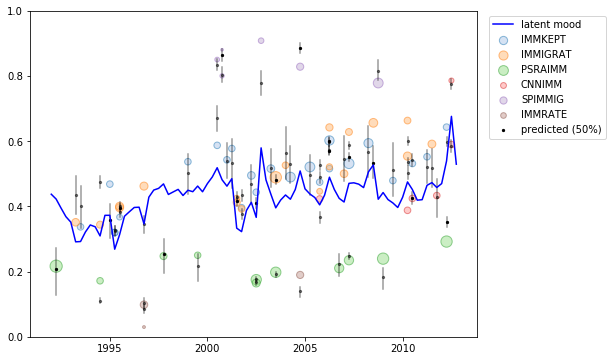

In [151]:
# TONE, logSTORIES, TONE x logSTORIES

fig, ax = plotting.plot_polling_data(polls)

n_questions = int(polls.question.max() + 1)
n_periods = len(grouped.index)
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
p_t_mean = np.zeros(n_periods)

tones = grouped.tone.values
logStories = grouped.logStories.values
toneXlogStories = tones * logStories
entropy = grouped.entropy.values
toneXentropy = tones * entropy

X = np.vstack([tones, logStories, toneXlogStories]).T
n_periods, K = X.shape
print X.shape

n_folds = 5
for fold in range(n_folds):
    print "fold", fold
    polls_train = polls[polls.fold != fold]
    polls_test = polls[polls.fold == fold]
    N_train, _ = polls_train.shape
    N_test, _ = polls_test.shape
    question_indices = np.array(polls.question.values, dtype=int) + 1
    question_indicators_train = np.zeros([N_train, n_questions])
    question_indicators_test = np.zeros([N_test, n_questions])
    for i in range(N_train):
        question_indicators_train[i, polls_train.question.values[i]] = 1
    for i in range(N_test):
        question_indicators_test[i, polls_test.question.values[i]] = 1

    y_train = np.array((polls_train.value * polls_train.N).values, dtype=int)
    y_test = np.array((polls_test.value * polls_test.N).values, dtype=int)
    t_train = np.array(polls_train.period.values, dtype=int) + 1
    t_test = np.array(polls_test.period.values, dtype=int) + 1
        
    stan_data = {'N': N_train, 'T': n_periods, 'K':K, 'Q': n_questions,
                 'y': y_train, 't': t_train, 'n': polls_train.N.values, 'q': question_indicators_train, 'X': X,
                 'N_new': N_test,
                 'y_new': y_test, 't_new': t_test, 'n_new': polls_test.N.values, 'q_new': question_indicators_test}
    fit = pystan.stan(model_code=model, data=stan_data, iter=1000, chains=4)

    p_t = fit.extract('p_t')['p_t']
    p_t_mean += np.mean(p_t, axis=0)
    p_i_new = fit.extract('p_i_new')['p_i_new']
    p_i_new_means = np.mean(p_i_new, axis=0)
    p_i_new_25 = np.percentile(p_i_new, 25, axis=0)
    p_i_new_75 = np.percentile(p_i_new, 75, axis=0)
    s_new = fit.extract('s_new')['s_new'] 
    s_new_mean = np.mean(s_new, axis=0) / polls_test.N.values
    s_new_25 = np.percentile(s_new, 25, axis=0) / polls_test.N.values
    s_new_75 = np.percentile(s_new, 75, axis=0) / polls_test.N.values
    x = [first_year + (q) * 0.25 for q in range(n_periods)]
    #ax.fill_between(x,  p_t_means+p_t_std*2, p_t_means-p_t_std*2, facecolor='grey', edgecolor='white', alpha=0.3, label=None)
    if fold == 0:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label='latent mood')
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label='predicted (50%)')
    else:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label=None)
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label=None, alpha=0.5)
    for i in range(N_test):
        f_date = polls_test.f_date.iloc[i]
        ax.plot([f_date, f_date], [s_new_25[i], s_new_75[i]], 'k', label=None, alpha=0.4)
        
    gamma = fit.extract('gamma')['gamma']
    print np.mean(gamma, axis=0)
    print np.std(gamma, axis=0)

ax.plot(x, p_t_mean/float(n_folds), 'b', label='latent mood')
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

from scipy.misc import logsumexp
log_p_new = fit.extract('log_p_new')['log_p_new']
n_iter = log_p_new.size
posterior_predictive = logsumexp(log_p_new) - np.log(n_iter)
print "log_p_new: %0.2f" % posterior_predictive

/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


Question	Responses
 IMMKEPT	24
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3
(84, 1)
fold 0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


0.873411320045
0.651128807537
fold 1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


0.787286883372
0.556246524556
fold 2


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


1.10039963455
0.72363913538
fold 3


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


0.630215900927
0.845380161139
fold 4
0.818981176592
0.650689744296
log_p_new: -79.71


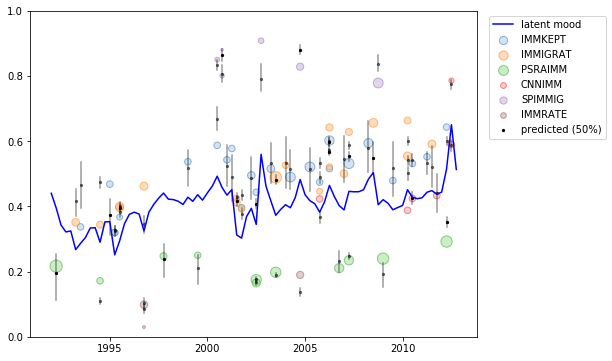

In [152]:
#  TONE x logSTORIES

fig, ax = plotting.plot_polling_data(polls)

n_questions = int(polls.question.max() + 1)
n_periods = len(grouped.index)
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
p_t_mean = np.zeros(n_periods)

tones = grouped.tone.values
logStories = grouped.logStories.values
toneXlogStories = tones * logStories
entropy = grouped.entropy.values
toneXentropy = tones * entropy

X = np.vstack([toneXlogStories]).T
n_periods, K = X.shape
print X.shape

n_folds = 5
for fold in range(n_folds):
    print "fold", fold
    polls_train = polls[polls.fold != fold]
    polls_test = polls[polls.fold == fold]
    N_train, _ = polls_train.shape
    N_test, _ = polls_test.shape
    question_indices = np.array(polls.question.values, dtype=int) + 1
    question_indicators_train = np.zeros([N_train, n_questions])
    question_indicators_test = np.zeros([N_test, n_questions])
    for i in range(N_train):
        question_indicators_train[i, polls_train.question.values[i]] = 1
    for i in range(N_test):
        question_indicators_test[i, polls_test.question.values[i]] = 1

    y_train = np.array((polls_train.value * polls_train.N).values, dtype=int)
    y_test = np.array((polls_test.value * polls_test.N).values, dtype=int)
    t_train = np.array(polls_train.period.values, dtype=int) + 1
    t_test = np.array(polls_test.period.values, dtype=int) + 1
        
    stan_data = {'N': N_train, 'T': n_periods, 'K':K, 'Q': n_questions,
                 'y': y_train, 't': t_train, 'n': polls_train.N.values, 'q': question_indicators_train, 'X': X,
                 'N_new': N_test,
                 'y_new': y_test, 't_new': t_test, 'n_new': polls_test.N.values, 'q_new': question_indicators_test}
    fit = pystan.stan(model_code=model, data=stan_data, iter=1000, chains=4)

    p_t = fit.extract('p_t')['p_t']
    p_t_mean += np.mean(p_t, axis=0)
    p_i_new = fit.extract('p_i_new')['p_i_new']
    p_i_new_means = np.mean(p_i_new, axis=0)
    p_i_new_25 = np.percentile(p_i_new, 25, axis=0)
    p_i_new_75 = np.percentile(p_i_new, 75, axis=0)
    s_new = fit.extract('s_new')['s_new'] 
    s_new_mean = np.mean(s_new, axis=0) / polls_test.N.values
    s_new_25 = np.percentile(s_new, 25, axis=0) / polls_test.N.values
    s_new_75 = np.percentile(s_new, 75, axis=0) / polls_test.N.values
    x = [first_year + (q) * 0.25 for q in range(n_periods)]
    #ax.fill_between(x,  p_t_means+p_t_std*2, p_t_means-p_t_std*2, facecolor='grey', edgecolor='white', alpha=0.3, label=None)
    if fold == 0:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label='latent mood')
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label='predicted (50%)')
    else:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label=None)
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label=None, alpha=0.5)
    for i in range(N_test):
        f_date = polls_test.f_date.iloc[i]
        ax.plot([f_date, f_date], [s_new_25[i], s_new_75[i]], 'k', label=None, alpha=0.4)
        
    gamma = fit.extract('gamma')['gamma']
    print np.mean(gamma, axis=0)
    print np.std(gamma, axis=0)

ax.plot(x, p_t_mean/float(n_folds), 'b', label='latent mood')
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

from scipy.misc import logsumexp
log_p_new = fit.extract('log_p_new')['log_p_new']
n_iter = log_p_new.size
posterior_predictive = logsumexp(log_p_new) - np.log(n_iter)
print "log_p_new: %0.2f" % posterior_predictive

/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


Question	Responses
 IMMKEPT	24
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3
(84, 3)
fold 0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 1.10262785  0.25412361 -1.06129495]
[ 0.59061658  0.11925901  0.78258288]
fold 1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.86198641  0.16151696 -1.67015361]
[ 0.49706586  0.09926367  0.73459725]
fold 2


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 1.05484792  0.29286725 -0.91579853]
[ 0.6215425   0.12655096  0.73845929]
fold 3


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 1.18099409  0.19435421 -0.96811187]
[ 0.87136071  0.16441818  1.04894767]
fold 4
[ 0.87731914  0.21578516 -0.86383855]
[ 0.57604179  0.11909663  0.74040625]
log_p_new: -74.03


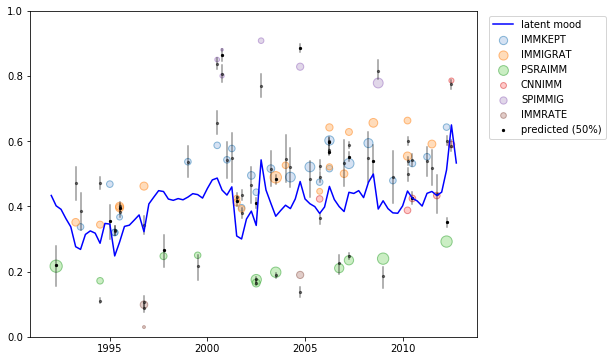

In [153]:
# TONE, logSTORIES, ENTROPY

fig, ax = plotting.plot_polling_data(polls)

n_questions = int(polls.question.max() + 1)
n_periods = len(grouped.index)
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
p_t_mean = np.zeros(n_periods)

tones = grouped.tone.values
logStories = grouped.logStories.values
#toneXlogStories = tones * logStories
entropy = grouped.entropy.values
toneXentropy = tones * entropy

X = np.vstack([tones, logStories, entropy]).T
n_periods, K = X.shape
print X.shape

n_folds = 5
for fold in range(n_folds):
    print "fold", fold
    polls_train = polls[polls.fold != fold]
    polls_test = polls[polls.fold == fold]
    N_train, _ = polls_train.shape
    N_test, _ = polls_test.shape
    question_indices = np.array(polls.question.values, dtype=int) + 1
    question_indicators_train = np.zeros([N_train, n_questions])
    question_indicators_test = np.zeros([N_test, n_questions])
    for i in range(N_train):
        question_indicators_train[i, polls_train.question.values[i]] = 1
    for i in range(N_test):
        question_indicators_test[i, polls_test.question.values[i]] = 1

    y_train = np.array((polls_train.value * polls_train.N).values, dtype=int)
    y_test = np.array((polls_test.value * polls_test.N).values, dtype=int)
    t_train = np.array(polls_train.period.values, dtype=int) + 1
    t_test = np.array(polls_test.period.values, dtype=int) + 1
        
    stan_data = {'N': N_train, 'T': n_periods, 'K':K, 'Q': n_questions,
                 'y': y_train, 't': t_train, 'n': polls_train.N.values, 'q': question_indicators_train, 'X': X,
                 'N_new': N_test,
                 'y_new': y_test, 't_new': t_test, 'n_new': polls_test.N.values, 'q_new': question_indicators_test}
    fit = pystan.stan(model_code=model, data=stan_data, iter=1000, chains=4)

    p_t = fit.extract('p_t')['p_t']
    p_t_mean += np.mean(p_t, axis=0)
    p_i_new = fit.extract('p_i_new')['p_i_new']
    p_i_new_means = np.mean(p_i_new, axis=0)
    p_i_new_25 = np.percentile(p_i_new, 25, axis=0)
    p_i_new_75 = np.percentile(p_i_new, 75, axis=0)
    s_new = fit.extract('s_new')['s_new'] 
    s_new_mean = np.mean(s_new, axis=0) / polls_test.N.values
    s_new_25 = np.percentile(s_new, 25, axis=0) / polls_test.N.values
    s_new_75 = np.percentile(s_new, 75, axis=0) / polls_test.N.values
    x = [first_year + (q) * 0.25 for q in range(n_periods)]
    #ax.fill_between(x,  p_t_means+p_t_std*2, p_t_means-p_t_std*2, facecolor='grey', edgecolor='white', alpha=0.3, label=None)
    if fold == 0:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label='latent mood')
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label='predicted (50%)')
    else:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label=None)
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label=None, alpha=0.5)
    for i in range(N_test):
        f_date = polls_test.f_date.iloc[i]
        ax.plot([f_date, f_date], [s_new_25[i], s_new_75[i]], 'k', label=None, alpha=0.4)
        
    gamma = fit.extract('gamma')['gamma']
    print np.mean(gamma, axis=0)
    print np.std(gamma, axis=0)

ax.plot(x, p_t_mean/float(n_folds), 'b', label='latent mood')
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

from scipy.misc import logsumexp
log_p_new = fit.extract('log_p_new')['log_p_new']
n_iter = log_p_new.size
posterior_predictive = logsumexp(log_p_new) - np.log(n_iter)
print "log_p_new: %0.2f" % posterior_predictive

/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


Question	Responses
 IMMKEPT	24
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3
(84, 4)
fold 0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.49708553  0.25118505 -0.8599436   0.29350146]
[ 1.05618017  0.11535485  0.77783963  0.45716677]
fold 1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.53275383  0.16856378 -1.47835708  0.14152389]
[ 1.5004768   0.10179038  0.85781377  0.63404336]
fold 2


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.40419465  0.28626727 -0.62684507  0.30824379]
[ 1.29947138  0.12797112  0.78593189  0.56516038]
fold 3


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.45387548  0.22077869 -0.77337192  0.42147117]
[ 1.18015844  0.16729919  0.9833671   0.55046445]
fold 4
[ 0.33090349  0.22492942 -0.76612015  0.29865029]
[ 1.01982949  0.11434796  0.86106352  0.45076894]
log_p_new: -76.45


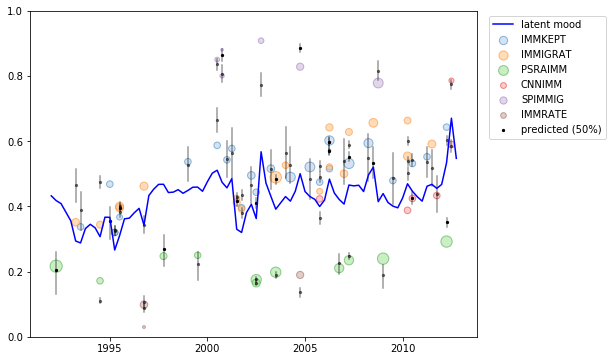

In [154]:
# TONE, logSTORIES, ENTROPY, TONE x ENTROPY

fig, ax = plotting.plot_polling_data(polls)

n_questions = int(polls.question.max() + 1)
n_periods = len(grouped.index)
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
p_t_mean = np.zeros(n_periods)

tones = grouped.tone.values
logStories = grouped.logStories.values
#toneXlogStories = tones * logStories
entropy = grouped.entropy.values
toneXentropy = tones * entropy

X = np.vstack([tones, logStories, entropy, toneXentropy]).T
n_periods, K = X.shape
print X.shape

n_folds = 5
for fold in range(n_folds):
    print "fold", fold
    polls_train = polls[polls.fold != fold]
    polls_test = polls[polls.fold == fold]
    N_train, _ = polls_train.shape
    N_test, _ = polls_test.shape
    question_indices = np.array(polls.question.values, dtype=int) + 1
    question_indicators_train = np.zeros([N_train, n_questions])
    question_indicators_test = np.zeros([N_test, n_questions])
    for i in range(N_train):
        question_indicators_train[i, polls_train.question.values[i]] = 1
    for i in range(N_test):
        question_indicators_test[i, polls_test.question.values[i]] = 1

    y_train = np.array((polls_train.value * polls_train.N).values, dtype=int)
    y_test = np.array((polls_test.value * polls_test.N).values, dtype=int)
    t_train = np.array(polls_train.period.values, dtype=int) + 1
    t_test = np.array(polls_test.period.values, dtype=int) + 1
        
    stan_data = {'N': N_train, 'T': n_periods, 'K':K, 'Q': n_questions,
                 'y': y_train, 't': t_train, 'n': polls_train.N.values, 'q': question_indicators_train, 'X': X,
                 'N_new': N_test,
                 'y_new': y_test, 't_new': t_test, 'n_new': polls_test.N.values, 'q_new': question_indicators_test}
    fit = pystan.stan(model_code=model, data=stan_data, iter=1000, chains=4)

    p_t = fit.extract('p_t')['p_t']
    p_t_mean += np.mean(p_t, axis=0)
    p_i_new = fit.extract('p_i_new')['p_i_new']
    p_i_new_means = np.mean(p_i_new, axis=0)
    p_i_new_25 = np.percentile(p_i_new, 25, axis=0)
    p_i_new_75 = np.percentile(p_i_new, 75, axis=0)
    s_new = fit.extract('s_new')['s_new'] 
    s_new_mean = np.mean(s_new, axis=0) / polls_test.N.values
    s_new_25 = np.percentile(s_new, 25, axis=0) / polls_test.N.values
    s_new_75 = np.percentile(s_new, 75, axis=0) / polls_test.N.values
    x = [first_year + (q) * 0.25 for q in range(n_periods)]
    #ax.fill_between(x,  p_t_means+p_t_std*2, p_t_means-p_t_std*2, facecolor='grey', edgecolor='white', alpha=0.3, label=None)
    if fold == 0:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label='latent mood')
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label='predicted (50%)')
    else:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label=None)
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label=None, alpha=0.5)
    for i in range(N_test):
        f_date = polls_test.f_date.iloc[i]
        ax.plot([f_date, f_date], [s_new_25[i], s_new_75[i]], 'k', label=None, alpha=0.4)
        
    gamma = fit.extract('gamma')['gamma']
    print np.mean(gamma, axis=0)
    print np.std(gamma, axis=0)

ax.plot(x, p_t_mean/float(n_folds), 'b', label='latent mood')
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

from scipy.misc import logsumexp
log_p_new = fit.extract('log_p_new')['log_p_new']
n_iter = log_p_new.size
posterior_predictive = logsumexp(log_p_new) - np.log(n_iter)
print "log_p_new: %0.2f" % posterior_predictive